## kriging the bottom of the aquifer - we can remove this if we want

In [1]:
import pyemu
import os
import numpy as np
import pandas as pd
import flopy as fp
import freyberg as fb
WD = "kriging"
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

# calculate and plot empirical variogram
def plot_empirical_variogram(x,y,data, nbins=25):

    X,Y = np.meshgrid(x,y)
    h = np.sqrt((X-X.T)**2 + (Y-Y.T)**2).ravel()
    d,d1 = np.meshgrid(data, data)
    gam = (1/2.0*(d-d.T)**2).ravel()
    if nbins>0:
        
        bindiffs = np.ones(nbins)*np.max(h)/2/nbins
        bins = np.hstack(([0],np.cumsum(bindiffs)))
        bindiffs[0] = bins[1]/2
        bincenters = np.cumsum(bindiffs)
    
        empirical_vario = list()
        for i in range(len(bincenters)):
            cinds = np.where((h>bins[i]) & (h<=bins[i+1]))
            empirical_vario.append(np.mean(gam[cinds]))
        h=bincenters
        gam = np.array(empirical_vario)

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    plt.scatter(h,gam)
    plt.xlabel('Separation Distance')
    plt.ylabel('Empirical Variogram')
    plt.grid()
    return h, gam, ax

In [3]:
fb.prep_notebook(WD)

In [4]:
fb.build_model(model_ws = WD);

Note: external_path . already exists
[[  1.70080000e+01   1.85070000e+01   1.86720000e+01   1.59300000e+01
    1.39610000e+01   1.44620000e+01   8.01900000e+00   1.06000000e+01
    8.88470000e+00   7.22740000e+00   6.25110000e+00   6.00610000e+00
    7.11430000e+00   6.90390000e+00   6.24430000e+00   6.94500000e+00
    6.98550000e+00   5.03100000e+00   4.00610000e+00   6.65840000e+00]
 [  1.91260000e+01   1.73450000e+01   1.82340000e+01   1.36600000e+01
    1.32620000e+01   1.39220000e+01   1.06760000e+01   9.91670000e+00
    1.10250000e+01   6.40940000e+00   4.87820000e+00   5.08430000e+00
    6.53210000e+00   5.17730000e+00   5.71810000e+00   4.33290000e+00
    5.88670000e+00   6.43560000e+00   5.29410000e+00   6.05030000e+00]
 [  1.74800000e+01   1.88600000e+01   1.82960000e+01   1.29860000e+01
    1.37380000e+01   1.44010000e+01   9.20200000e+00   1.12080000e+01
    8.34990000e+00   8.57420000e+00   5.98100000e+00   6.51990000e+00
    6.24530000e+00   5.00660000e+00   7.17200000e+0

In [5]:
m = fp.modflow.Modflow.load('freyberg.nam', model_ws=WD)

In [10]:
m.sr

xul:0; yul:10000; rotation:0; proj4_str:+init=EPSG:4326; units:meters; lenuni:2; length_multiplier:1.0

In [11]:
botraw = pd.read_csv(os.path.join('..','_data','bottoms_raw.dat'), delim_whitespace=True)
botraw.head()

,Name,Row,Column,Bottom_Elev
0,cr04c17,4,17,6.0
1,cr04c11,4,11,3.0
2,cr05c10,5,10,6.0
3,cr11c3,11,3,14.0
4,cr15c12,15,12,1.5


In [12]:
for i in ['Row','Column']:
    botraw[i]-=1 

In [13]:
botraw.head()

,Name,Row,Column,Bottom_Elev
0,cr04c17,3,16,6.0
1,cr04c11,3,10,3.0
2,cr05c10,4,9,6.0
3,cr11c3,10,2,14.0
4,cr15c12,14,11,1.5


In [14]:
x,y = m.sr.get_xcenter_array()[botraw.Column.values],m.sr.get_ycenter_array()[botraw.Row.values]

In [15]:
x

array([ 4125.,  2625.,  2375.,   625.,  2875.,  4375.,  2875.,  4125.,
        1375.,  1875.,  4125.,  2125.,  2875.,  2125.,  2875.,  3375.,
        3875.,  3125.,  3375.,  2375.,  1375.,  2875.])

In [16]:
y

array([ 9125.,  9125.,  8875.,  7375.,  6375.,  5875.,  4375.,  4125.,
        3625.,  3125.,  2375.,  1375.,  1125.,   125.,   125.,   125.,
        7875.,  7375.,  5125.,  3625.,  2875.,  1625.])

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mnfienen/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


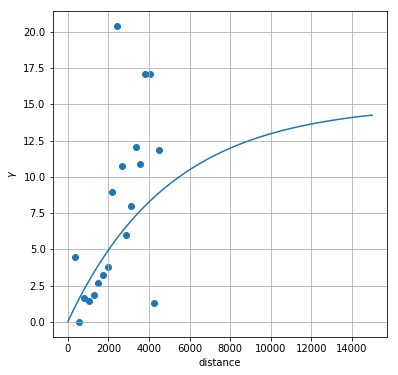

In [147]:
h,gam,ax=plot_empirical_variogram(x,y,botraw.Bottom_Elev,nbins=20)
v = pyemu.geostats.ExpVario(contribution=15, a=5000)
gs = pyemu.geostats.GeoStruct(variograms=v)
gs.plot(ax=ax)

In [148]:
X,Y = m.sr.xcentergrid,m.sr.ycentergrid

In [149]:
interp_df = pd.DataFrame({'name':['p{0}'.format(i) for i in range(len(botraw))], 'x' : x,'y':y, 'z':botraw.Bottom_Elev})

In [150]:
interp_df.index = interp_df.name

In [151]:
k =  pyemu.geostats.OrdinaryKrige(gs,interp_df)

In [152]:

kfac = k.calc_factors(X.ravel(),Y.ravel())

starting interp point loop for 800 points
took 2.607701 seconds


In [153]:
def geostat_interpolate(X,Y,interp_data, data_df):
    '''

    :param X: grid of X grid locations
    :param Y: grid of Y grid locations
    :param interp_data: dataframe of interpolation data greated by pyemu.geostats.OrdinaryKrige.calc_factors()
    :param data_df: xd, yd, zd, and names of points

    :return: Z -- an interpolated field
    '''

    dims = X.shape
    X = X.ravel()
    Y = Y.ravel()
    Z = np.zeros_like(X)
    i = 0
    for cp in interp_data.index:
        # alot going on in the next line! Get the locations from sample_df of the names for current point (cp)
        # then sort the results to be the same order as ifacts
        # then grab the zd values
        # make it 2d to take advantage of vectorization later
        cpts = np.atleast_2d(data_df.loc[data_df.name.isin(interp_data.loc[cp].inames)].loc[
            interp_data.loc[cp].inames].z.values)
        Z[i] = np.squeeze(cpts.dot(np.atleast_2d(interp_data.loc[cp].ifacts).T))
        i+=1
    return Z.reshape(dims)

In [154]:
Z_interp = geostat_interpolate(X,Y,k.interp_data,interp_df)

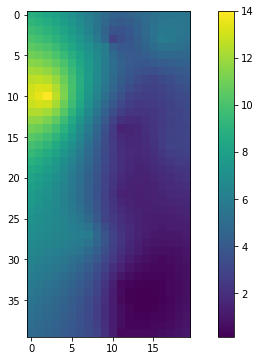

In [155]:
plt.figure(figsize=(10,6))
plt.imshow(Z_interp)
plt.colorbar()

In [156]:
botraw

,Name,Row,Column,Bottom_Elev
0,cr04c17,3,16,6.0
1,cr04c11,3,10,3.0
2,cr05c10,4,9,6.0
3,cr11c3,10,2,14.0
4,cr15c12,14,11,1.5
5,cr17c18,16,17,3.0
6,cr23c12,22,11,1.5
7,cr24c17,23,16,1.5
8,cr26c6,25,5,6.0
9,cr28c8,27,7,6.0


In [158]:
np.savetxt(os.path.join('..','_data','kriged_bottom_elevs.ref'), Z_interp)